# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from matplotlib.colors import LogNorm

Load feature names.

In [3]:
feature_names = []
with open('Data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

with open('Data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

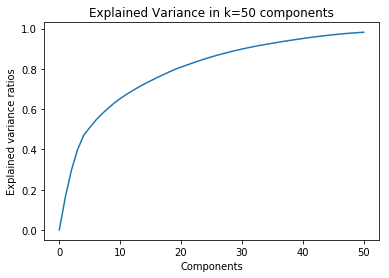

In [6]:
def P1():
### STUDENT START ###
    pca = PCA(n_components=50)
    pca.fit(train_data)
    
    var_ratio = np.cumsum(np.concatenate(([0], pca.explained_variance_ratio_)))

    # plot...
    plt.plot(range(0, 51), var_ratio)

    plt.xlabel("Components")
    plt.ylabel("Explained variance ratios")
    plt.title("Explained Variance in k=50 components")
    
    plt.show()
    
### STUDENT END ###

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

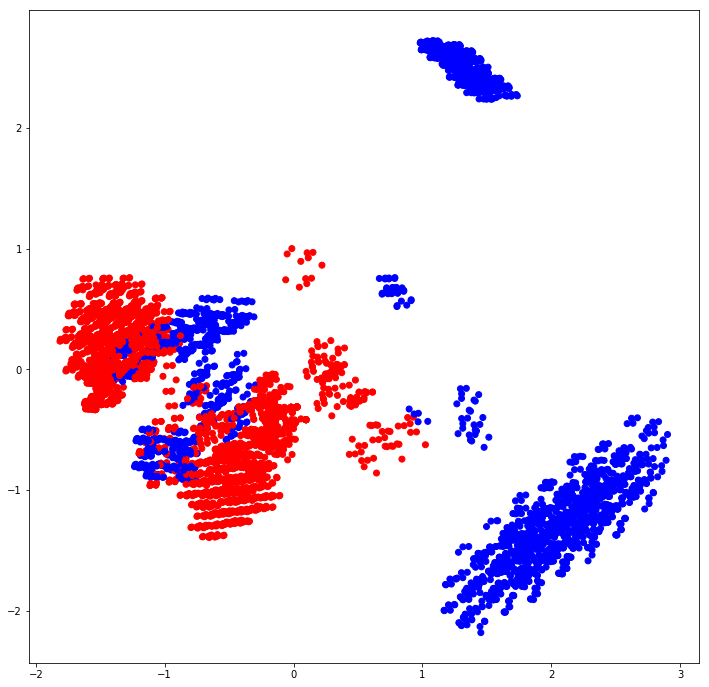

In [7]:
def P2():
### STUDENT START ###

    pca = PCA(n_components = 2)
    pca_data = pca.fit_transform(train_data)

    # plotting time...
    plt.figure(figsize=(12,12))
    colormap = {0: 'red', 1: 'blue'}
    colors = [colormap[x] for x in train_labels]
    plt.scatter(pca_data[:,0], pca_data[:,1], color=colors)
    plt.legend(frameon=False, numpoints=1)
    
    plt.show()

### STUDENT END ###

P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

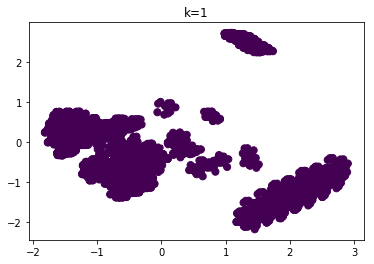

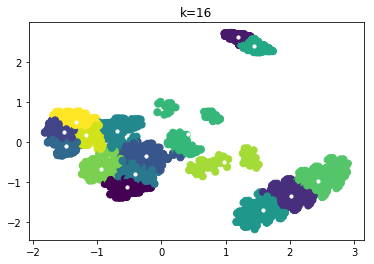

In [66]:
def P3():    
    pca = PCA(n_components = 2)
    pca = pca.fit_transform(train_data)
    
    #run kMeans for k=1 and k=16
    [run_kmeans(pca, k) for k in [1, 16]]
    
def run_kmeans(pca, k):
    kmeans = KMeans(n_clusters=k).fit(pca)
    predicted_cluster = kmeans.predict(pca)
    
    # Transform to a cluster-distance space.
    distance = kmeans.transform(pca)
    max_distance = np.max(distance)
    
    labels = kmeans.labels_
    centers = kmeans.cluster_centers_
    
    plt.figure()
    plt.scatter(pca[:, 0], pca[:, 1], c=predicted_cluster, s=50, cmap='viridis')
    plt.scatter(centers[:, 0], centers[:, 1], c='white', s=10, alpha=1.0);
    plt.title("k=" + str(k))

    # define centroid point. 
    # for each point, calculate the distance and mark the max distance.
    # at the end, circle the max distance
    # calculate distance point
    
P3()

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

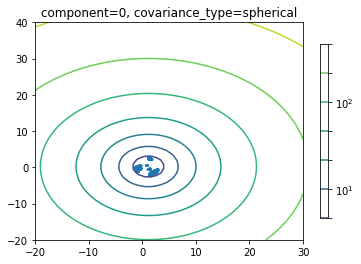

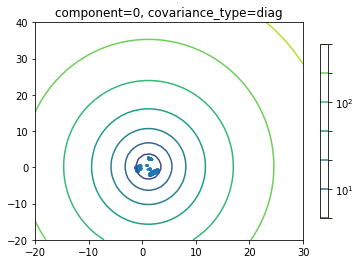

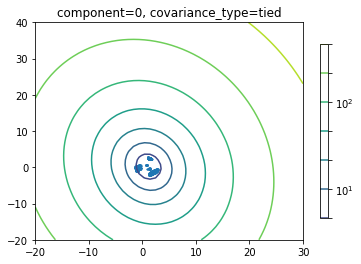

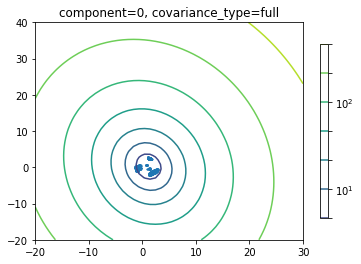

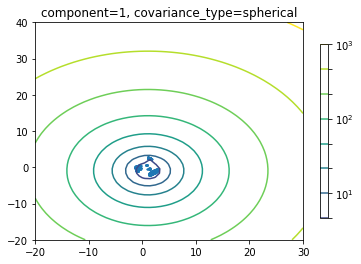

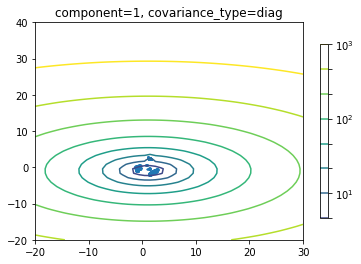

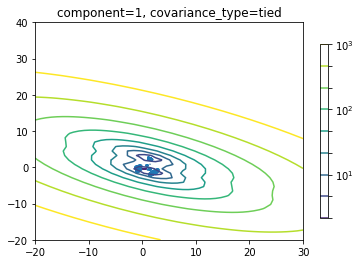

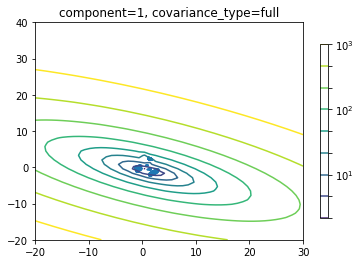

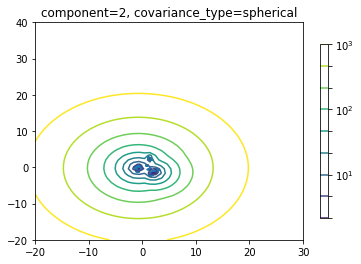

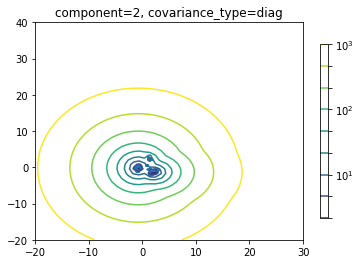

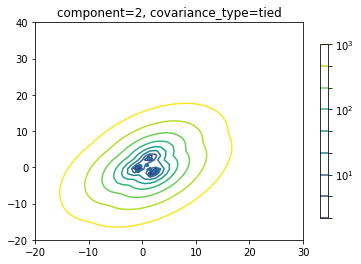

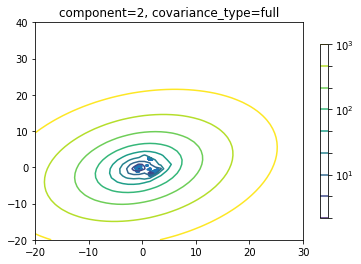

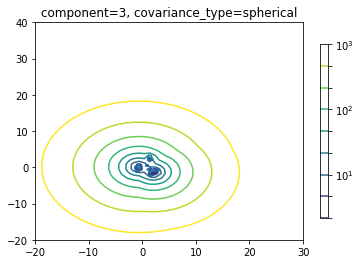

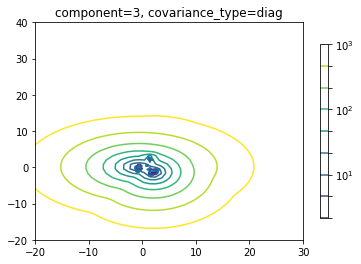

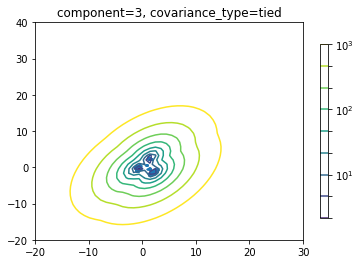

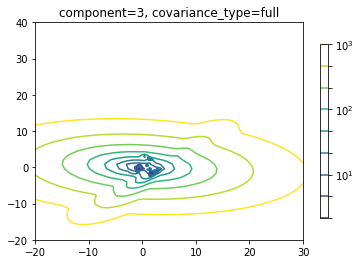

In [99]:
def P4():
    
    # Reduce train data to 2 dimensions 
    pca = PCA(n_components=2)
    pca = pca.fit_transform(train_data)
    # select positive samples
    positives = pca[train_labels == 1]
    
    # fit a Gaussian Mixture Model with two components
    for component in range(4):
        for covariance in ["spherical", "diag", "tied", "full"]:
            clf = GaussianMixture(n_components=component+1, covariance_type=covariance)
            clf.fit(positives)

            # display predicted scores by the model as a contour plot
            x = np.linspace(-20., 30.)
            y = np.linspace(-20., 40.)
            X, Y = np.meshgrid(x, y)
            XX = np.array([X.ravel(), Y.ravel()]).T
            Z = -clf.score_samples(XX)
            Z = Z.reshape(X.shape)

            CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0), levels=np.logspace(0, 3, 10))
            CB = plt.colorbar(CS, shrink=0.8, extend='both')
            plt.scatter(positives[:, 0], positives[:, 1], .8)
            
            title = "component={}, covariance_type={}".format(component, covariance)
            plt.title(title)
            plt.axis('tight')
            plt.show()
P4()

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [106]:
def P5():
### STUDENT START ###
    pca = PCA(n_components=2)
    pca_train = pca.fit_transform(train_data)
    pca_test = pca.transform(test_data)
    
    # select positive and negative samples
    positives = pca_train[train_labels == 1]
    negatives = pca_train[train_labels == 0]
    
    gmm_model = GaussianMixture(n_components=4, covariance_type='full')
    
    # fit positives
    gmm_model.fit(positives)
    positive_score = gmm_model.score(pca_test)
    
    # fit negatives
    gmm_model.fit(negatives)
    negative_score = gmm_model.score(pca_test)
    
    # find accuracy..
    better_predicted_labbels = positive_score > negative_score
    accuracy = float(np.sum(test_labels==better_predicted_labbels))/len(test_labels)
    print ("The accuracy is {:.3f}.".format(accuracy))  

### STUDENT END ###

P5()

The accuracy is 0.639.


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

In [6]:
#def P6():
### STUDENT START ###

### STUDENT END ###

#P6()